In [1]:
# !pip install spinesTS

# MultiForecast

In [2]:
from spinesTS.data import LoadElectricDataSets, DataReader
from spinesTS.preprocessing import split_series
from spinesTS.ml_model import MultiOutputRegressor, MultiStepRegressor
from sklearn.preprocessing import StandardScaler
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

In [3]:
electric = LoadElectricDataSets()
ds = electric.dataset['value']
x_train, x_test, y_train, y_test = split_series(ds, ds, 10, 30, train_size=0.8)

In [4]:
msf = MultiStepRegressor(LGBMRegressor())
mof = MultiOutputRegressor(LGBMRegressor(), n_jobs=-1)

In [6]:
msf.fit(x_train, y_train)
mof.fit(x_train, y_train)
y_pred_msf = msf.predict(x_test)
y_pred_mof = mof.predict(x_test)
r2_score(y_test.T, y_pred_msf.T), r2_score(y_test.T, y_pred_mof.T)

(0.6850649543583034, 0.8053237748779316)

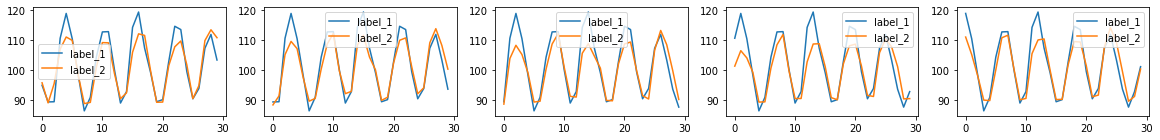

In [7]:
plot2d(y_test, y_pred_mof, fig_num_or_slice=slice(0, 5), figsize=(20, 2))

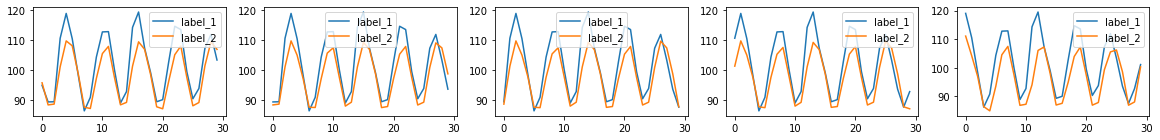

In [8]:
plot2d(y_test, y_pred_msf, fig_num_or_slice=slice(0, 5), figsize=(20, 2))

# Pipeline

In [8]:
from spinesTS.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor()))
])

In [10]:
multi_reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=0)

In [11]:
y_pred = multi_reg.predict(x_test)

In [12]:
r2_score(y_test.T, y_pred.T)

0.8068726243223835

## other algorithm pipeline

In [13]:
from spinesTS.datasets import LoadSupermarketIncoming
from spinesTS.nn import TCN1DTFModel, MLPTFModel
from spinesTS.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from spinesTS.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor

In [14]:
# capital loss data
cs = DataLoader('./tmp_data/capital_loss.csv')
cs_data = cs.data['set_replys']
x_train_cs, x_test_cs, y_train_cs, y_test_cs = split_series(cs_data, cs_data, 420, 420, train_size=0.8)

In [15]:
# Supermarket Incoming data
incoming = LoadSupermarketIncoming()
ds = incoming.data['goods_cnt']
x_train, x_test, y_train, y_test = split_series(ds, ds, 30, 30, train_size=0.8)

r2: -0.2039595900533938
mae: 107.74868579653841
mape: 1.0577195059278606


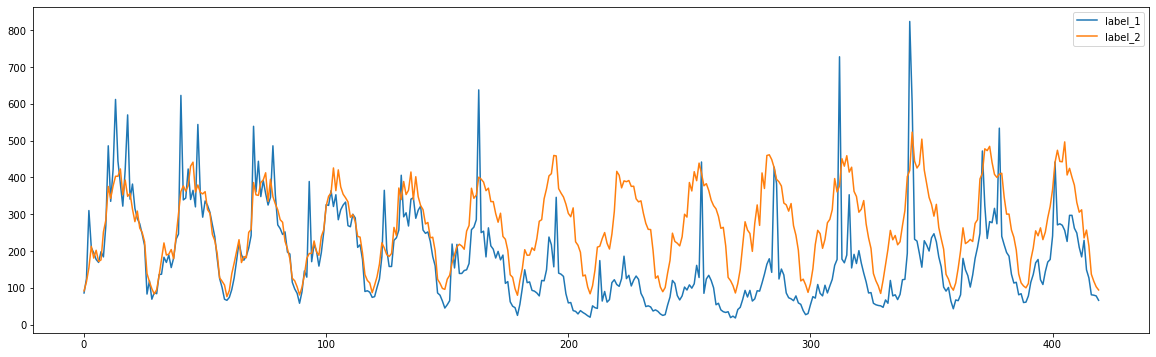

In [16]:
# capital loss data
from lightgbm import early_stopping
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(LGBMRegressor(n_jobs=-1)))
])
multi_reg.fit(x_train_cs, y_train_cs, eval_set=[(x_test_cs, y_test_cs)], 
              callbacks=[early_stopping(30, verbose=False)], 
              verbose=0)
y_pred_cs = multi_reg.predict(x_test_cs[-2:])
print(f"r2: {r2_score(y_test_cs[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test_cs[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test_cs[-2:], y_pred_cs)}")
plot2d(y_test_cs[-2:], y_pred_cs, fig_num_or_slice=slice(-1, None))

r2: -0.0009576075738633052
mae: 5726.205459550027
mape: 0.19538223296500024


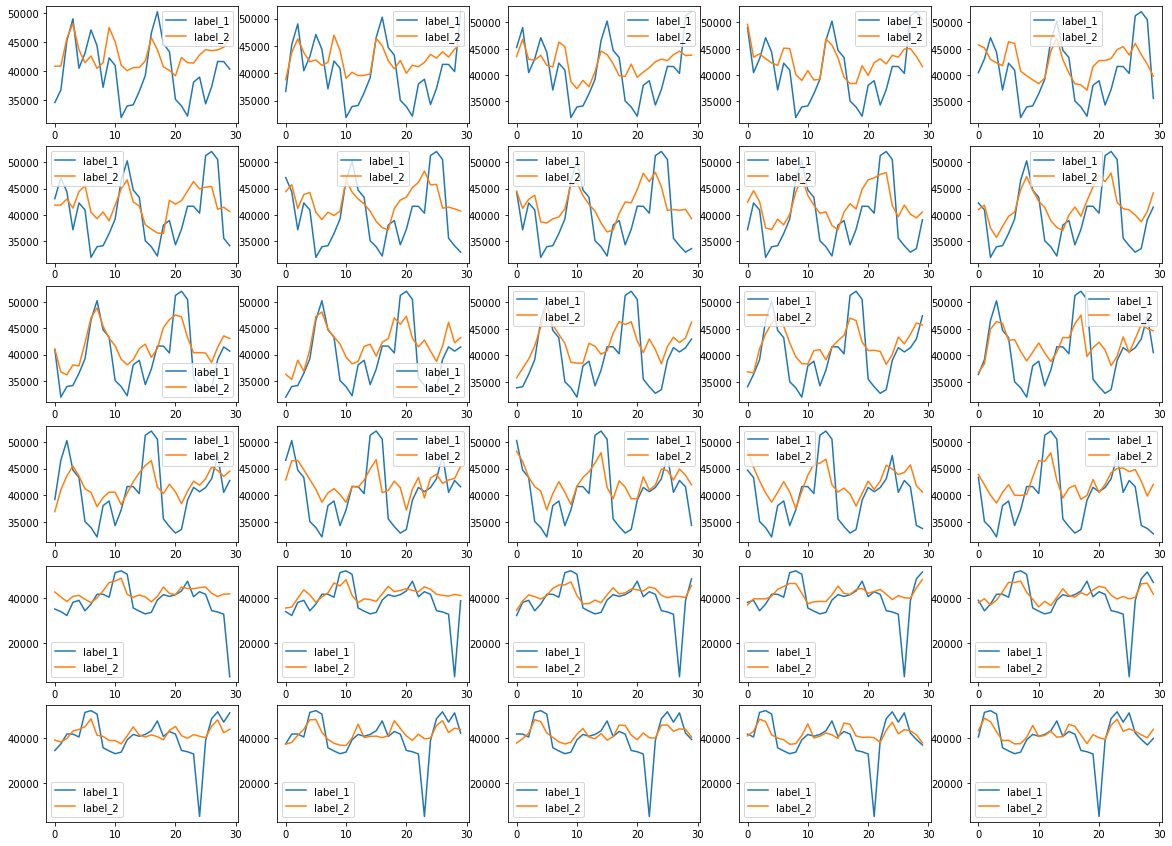

In [17]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)

### TCN

r2: -0.049577818540175476
mae: 5839.844288524683
mape: 0.19490506508658875


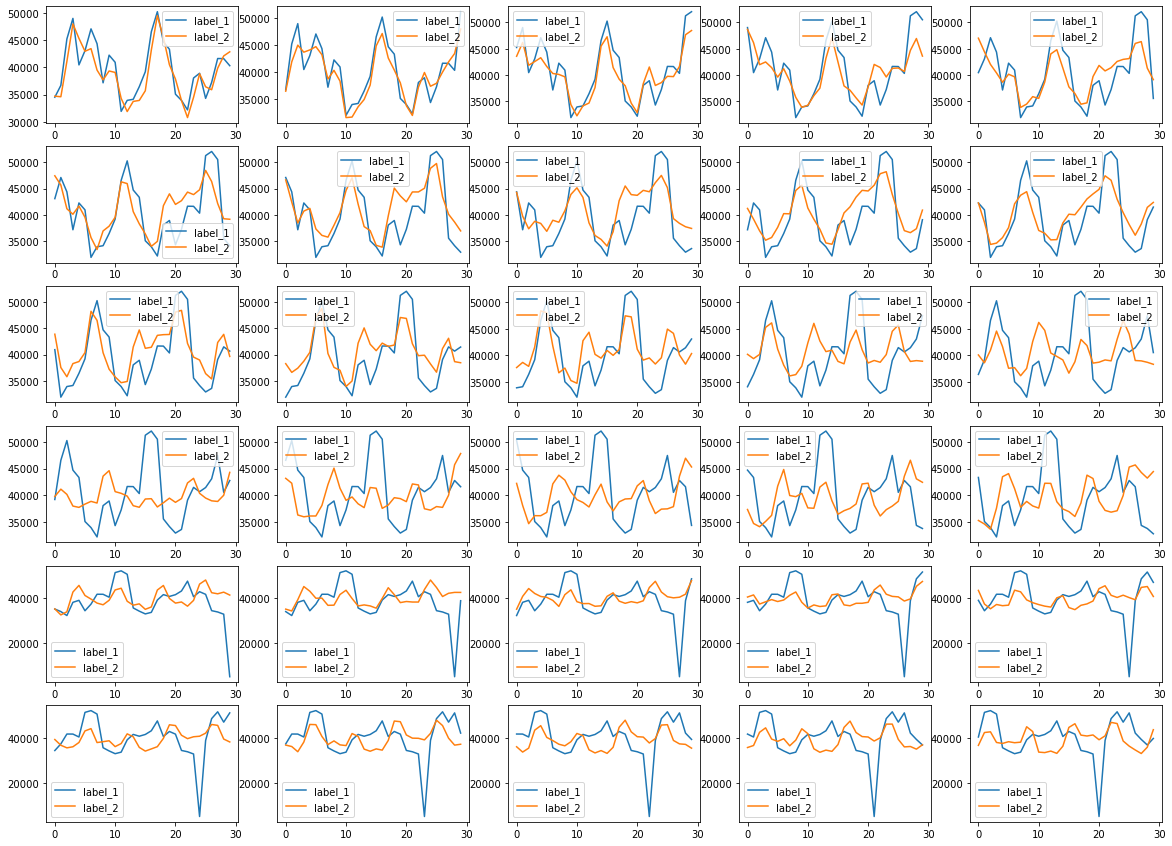

In [18]:
# nn
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', TCN1DTFModel(30, monitor='val_loss', patience=300, random_seed=666))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)

r2: 0.002321955501976114
mae: 5577.569502236187
mape: 0.18712313997093982


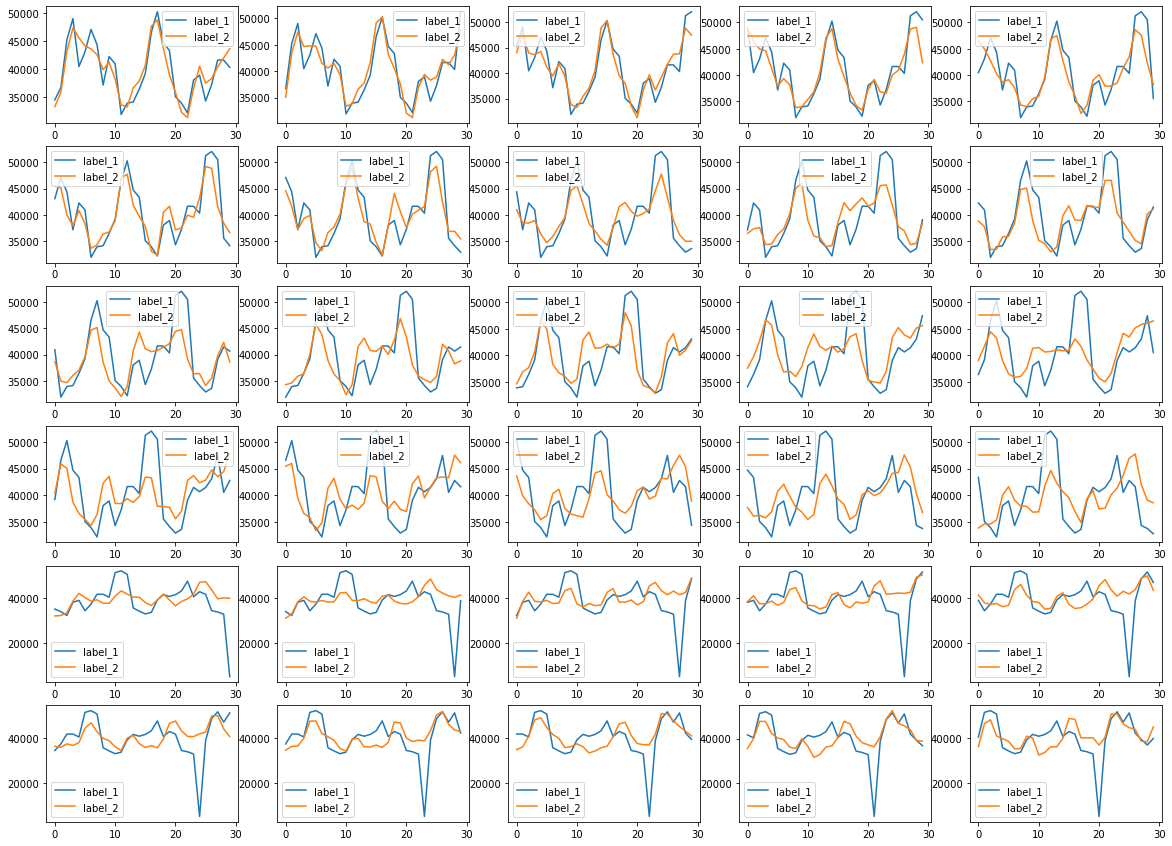

In [19]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', TCN1DTFModel(30, monitor='val_loss', patience=300, random_seed=666, tcn_blocks=2))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)

### MLP model

Epoch 1/1000
282/282 [==============================] - 27s 90ms/step - loss: 79.8370 - mae: 80.3353 - val_loss: 73.3248 - val_mae: 73.8231
Epoch 2/1000
282/282 [==============================] - 25s 89ms/step - loss: 62.6964 - mae: 63.1942 - val_loss: 70.2327 - val_mae: 70.7310
Epoch 3/1000
282/282 [==============================] - 25s 89ms/step - loss: 58.0866 - mae: 58.5842 - val_loss: 70.4224 - val_mae: 70.9206
Epoch 4/1000
282/282 [==============================] - 25s 89ms/step - loss: 54.9514 - mae: 55.4487 - val_loss: 68.2080 - val_mae: 68.7062
Epoch 5/1000
282/282 [==============================] - 25s 89ms/step - loss: 52.4131 - mae: 52.9102 - val_loss: 67.9145 - val_mae: 68.4127
Epoch 6/1000
282/282 [==============================] - 25s 89ms/step - loss: 50.3955 - mae: 50.8925 - val_loss: 67.5421 - val_mae: 68.0401
Epoch 7/1000
282/282 [==============================] - 25s 89ms/step - loss: 49.0253 - mae: 49.5222 - val_loss: 67.8785 - val_mae: 68.3765
Epoch 8/1000
282/282

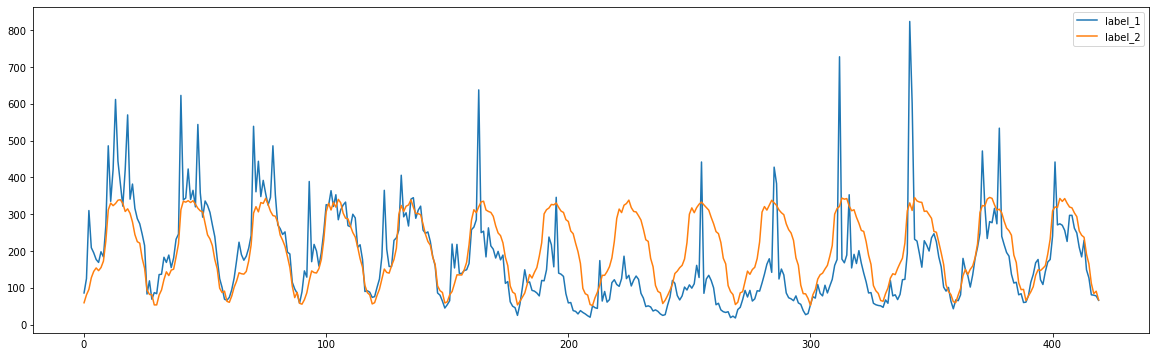

In [20]:
import tensorflow as tf

tf.keras.backend.clear_session()
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MLPTFModel(420, monitor='val_loss', patience=10, random_seed=666, 
                             res_dense_blocks=1))
])
multi_reg.fit(x_train_cs, y_train_cs, eval_set=(x_test_cs[:-2], y_test_cs[:-2]), verbose=1, batch_size=32)
y_pred_cs = multi_reg.predict(x_test_cs[-2:])
print(f"r2: {r2_score(y_test_cs[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test_cs[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test_cs[-2:], y_pred_cs)}")
plot2d(y_test_cs[-2:], y_pred_cs, fig_num_or_slice=slice(-1, None))

Epoch 1/1000
282/282 [==============================] - 28s 91ms/step - loss: 77.9746 - mae: 78.4729 - val_loss: 72.6684 - val_mae: 73.1667
Epoch 2/1000
282/282 [==============================] - 25s 89ms/step - loss: 58.8634 - mae: 59.3610 - val_loss: 70.9583 - val_mae: 71.4566
Epoch 3/1000
282/282 [==============================] - 25s 90ms/step - loss: 54.9902 - mae: 55.4876 - val_loss: 69.5609 - val_mae: 70.0591
Epoch 4/1000
282/282 [==============================] - 25s 90ms/step - loss: 51.5989 - mae: 52.0960 - val_loss: 68.7116 - val_mae: 69.2097
Epoch 5/1000
282/282 [==============================] - 25s 90ms/step - loss: 49.1207 - mae: 49.6177 - val_loss: 70.2158 - val_mae: 70.7140
Epoch 6/1000
282/282 [==============================] - 25s 90ms/step - loss: 47.2320 - mae: 47.7287 - val_loss: 69.3349 - val_mae: 69.8330
Epoch 7/1000
282/282 [==============================] - 25s 90ms/step - loss: 45.7805 - mae: 46.2770 - val_loss: 69.3586 - val_mae: 69.8567
Epoch 8/1000
282/282

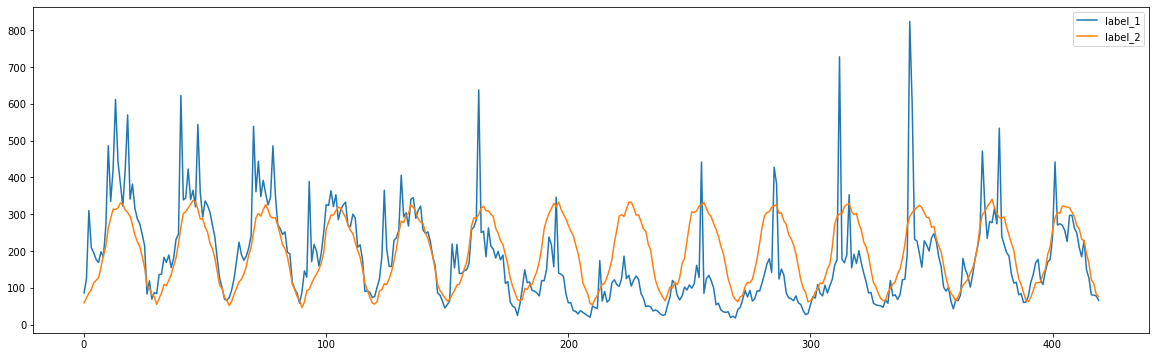

In [21]:
import tensorflow as tf

tf.keras.backend.clear_session()
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MLPTFModel(420, monitor='val_loss', patience=10, random_seed=666, 
                             res_dense_blocks=4))
])
multi_reg.fit(x_train_cs, y_train_cs, eval_set=(x_test_cs[:-2], y_test_cs[:-2]), verbose=1, batch_size=32)
y_pred_cs = multi_reg.predict(x_test_cs[-2:])
print(f"r2: {r2_score(y_test_cs[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test_cs[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test_cs[-2:], y_pred_cs)}")
plot2d(y_test_cs[-2:], y_pred_cs, fig_num_or_slice=slice(-1, None))

r2: -0.3324818269690771
mae: 6868.646671195652
mape: 0.22846143598383578


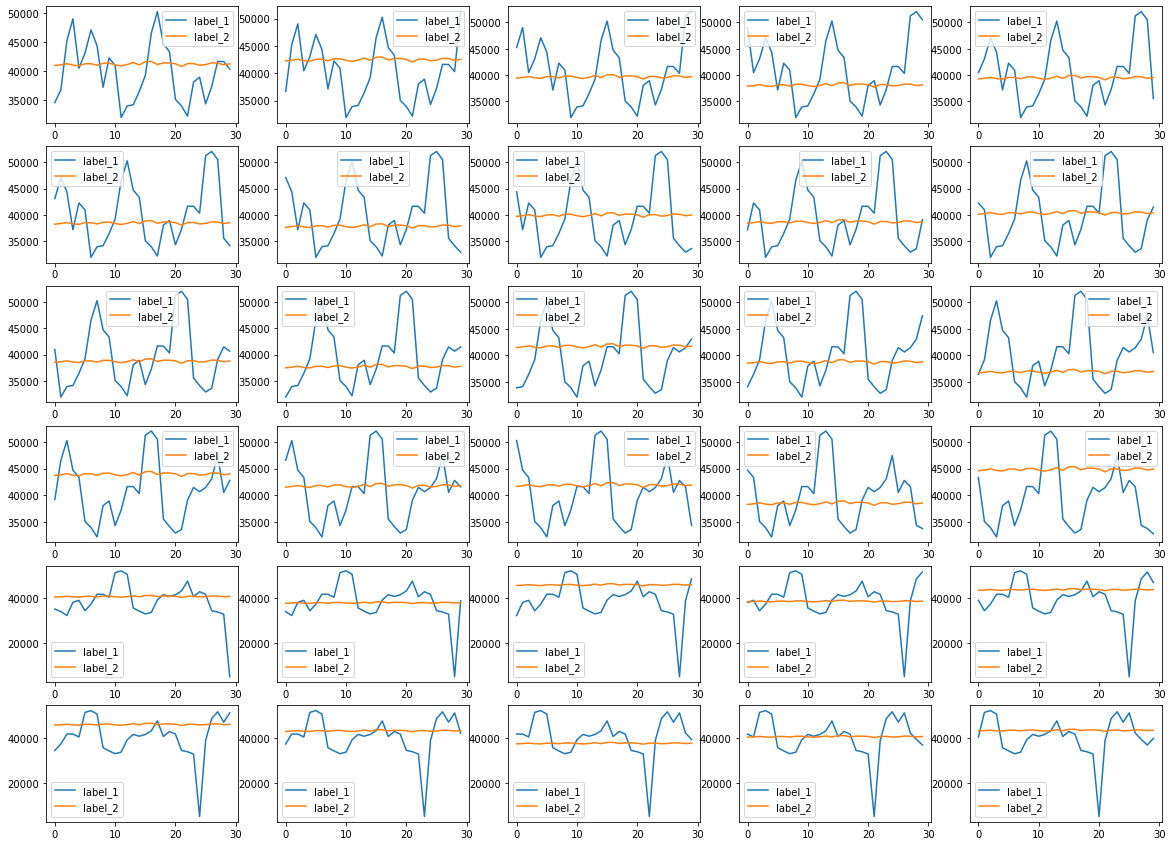

In [22]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MLPTFModel(30, monitor='val_loss', patience=300, random_seed=666))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)

r2: -0.33263776498444686
mae: 6868.915344769021
mape: 0.22846379231615507


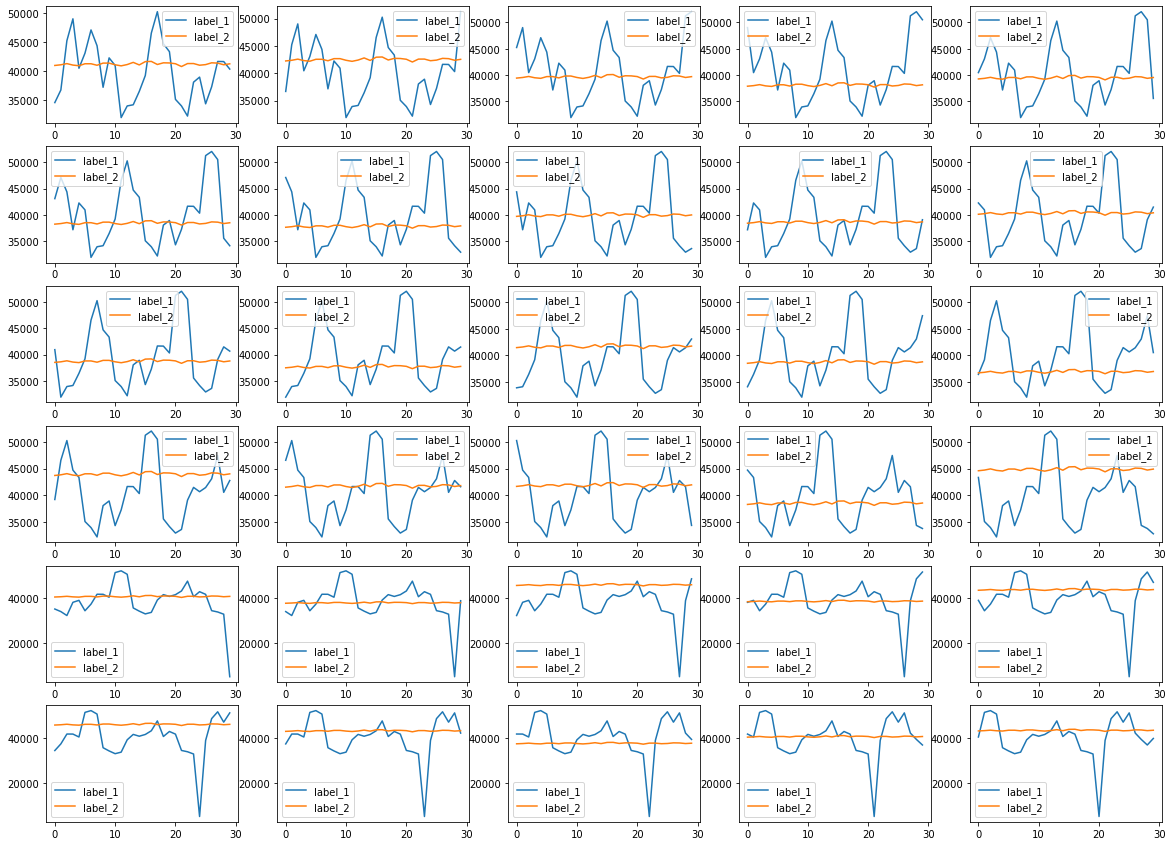

In [23]:
multi_reg = Pipeline([
    ('sc', StandardScaler()),
    ('multi_reg', MLPTFModel(30, monitor='val_loss', patience=300, random_seed=666))
])
multi_reg.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)

## feature extract

r2: -0.005758681100782564
mae: 5751.20019886425
mape: 0.19684469766176835


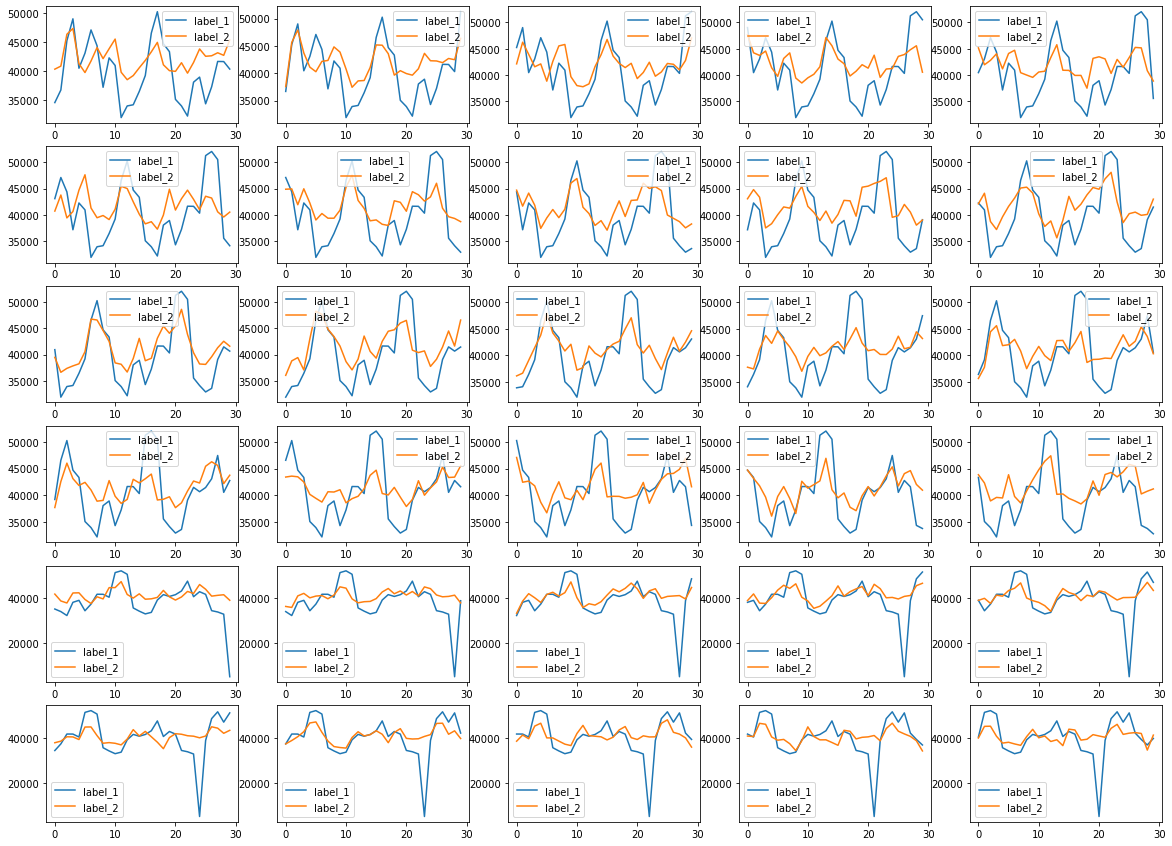

In [24]:
from spinesTS.feature_extract import FeatureExtractor
from catboost import CatBoostRegressor
multi_reg = Pipeline([
    ('fe', FeatureExtractor()),
    ('sc', StandardScaler()),
    ('multi_reg', MultiOutputRegressor(CatBoostRegressor(use_best_model=True)))
])
multi_reg.fit(x_train, y_train, eval_set=([x_test, y_test]), use_best_model=True, verbose=0)
y_pred = multi_reg.predict(x_test)
print(f"r2: {r2_score(y_test.T, y_pred.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred)}")
plot2d(y_test, y_pred)